In [75]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import scipy as sp
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [76]:
# Treatments and their assosiated failure rates
healthy_rate = {'healthy': 0.009706}
treatment_failure_rates = {'mesalamine': 60,
                    'remicade': 60,
                    'humira': 32,
                    'entyvio': 60,
                    'skyrizi': 12.3,
                    'rinvoq': 86}
failure_rate = {'failure': 0}

### Defining the treatments to include based on most common clinical practice

In [77]:
def define_treatments():
    '''
    Defines the treatment options for Crohn's Disease.
    Takes no arguments. Returns a dictionary of treatment options.
    '''
    permutations = list(it.permutations(treatment_failure_rates.keys(), 6))
    treatment_progressions = {i: treatment for i, treatment in enumerate(permutations) if i < 51}
    return treatment_progressions

In [78]:
for i in range(51):
    print(define_treatments()[i])

('mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq')
('mesalamine', 'remicade', 'humira', 'entyvio', 'rinvoq', 'skyrizi')
('mesalamine', 'remicade', 'humira', 'skyrizi', 'entyvio', 'rinvoq')
('mesalamine', 'remicade', 'humira', 'skyrizi', 'rinvoq', 'entyvio')
('mesalamine', 'remicade', 'humira', 'rinvoq', 'entyvio', 'skyrizi')
('mesalamine', 'remicade', 'humira', 'rinvoq', 'skyrizi', 'entyvio')
('mesalamine', 'remicade', 'entyvio', 'humira', 'skyrizi', 'rinvoq')
('mesalamine', 'remicade', 'entyvio', 'humira', 'rinvoq', 'skyrizi')
('mesalamine', 'remicade', 'entyvio', 'skyrizi', 'humira', 'rinvoq')
('mesalamine', 'remicade', 'entyvio', 'skyrizi', 'rinvoq', 'humira')
('mesalamine', 'remicade', 'entyvio', 'rinvoq', 'humira', 'skyrizi')
('mesalamine', 'remicade', 'entyvio', 'rinvoq', 'skyrizi', 'humira')
('mesalamine', 'remicade', 'skyrizi', 'humira', 'entyvio', 'rinvoq')
('mesalamine', 'remicade', 'skyrizi', 'humira', 'rinvoq', 'entyvio')
('mesalamine', 'remicade', 'skyriz

### Model Creation

- #1 incorporates treatment burden

In [79]:
# def simulate_model(x, t, params, treatment_order):
#     '''
#     Simulates a linear compartmental model for the progression of
#     patients through a treatment option.
#     Takes the following arguments:
#         x: a list of the initial values of the compartments
#         t: a list of time points to evaluate the model at
#         params: a dictionary of the parameters for the model
#     Returns a list of the values of the compartments at each time point.
#     '''
#     # Unpack the parameter rates
#     healthy_rate = 1/0.009706
#     rates = {treatment: 1/params[treatment] for treatment in treatment_order}
#     failure_rate = 1

#    # Unpack the initial values
#     num_patients = {treatment: x[i] for i, treatment in enumerate(treatment_order)}
#     num_failure = x[-3]
#     treatment_dalys = x[-2]
#     failure_dalys = x[-1]

#     dx = np.zeros(len(x))
#     dx[0] = -healthy_rate * num_patients[treatment_order[0]]
#     for i, treatment in enumerate(treatment_order):
#         if i == 0:
#             dx[i] = -rates[treatment] * num_patients[treatment]
#         else:
#             dx[i] = rates[treatment_order[i-1]] * num_patients[treatment_order[i-1]] - rates[treatment] * num_patients[treatment]
#     dx[-4] = rates[treatment_order[-1]] * num_patients[treatment_order[-1]]
#     dx[-3] = failure_rate * num_patients[treatment_order[-1]]

#     # Update the DALYs
#     treatment_daly_rate = 0.231  # DALYs per patient per year for treatment
#     failure_daly_rate = 0.095  # DALYs per patient per year for failure
#     dx[-2] = sum(treatment_daly_rate * num_patients[treatment] for treatment in treatment_order)
#     dx[-1] = failure_daly_rate * num_failure

#     return dx

- #2 does not incorporate burden

In [80]:
def simulate_model(x, t, params, treatment_order):
    '''
    Simulates a linear compartmental model for the progression of
    patients through a treatment option.
    Takes the following arguments:
        x: a list of the initial values of the compartments
        t: a list of time points to evaluate the model at
        params: a dictionary of the parameters for the model
    Returns a list of the values of the compartments at each time point.
    '''
    # Unpack the parameter rates
    healthy_rate = 1/0.009706
    rates = {treatment: 1/params[treatment] for treatment in treatment_order}
    failure_rate = 1

    # Unpack the initial values
    num_patients = {treatment: x[i] for i, treatment in enumerate(treatment_order)}
    num_failure = x[-1]

    dx = np.zeros(len(x))
    dx[0] = -healthy_rate * num_patients[treatment_order[0]]
    for i, treatment in enumerate(treatment_order):
        if i == 0:
            dx[i] = -rates[treatment] * num_patients[treatment]
        else:
            dx[i] = rates[treatment_order[i-1]] * num_patients[treatment_order[i-1]] - rates[treatment] * num_patients[treatment]
    dx[-2] = rates[treatment_order[-1]] * num_patients[treatment_order[-1]]
    dx[-1] = failure_rate * num_patients[treatment_order[-1]]

    return dx


In [81]:
# Initial values
num_healthy = 340000000 # 340 million people in the US
num_mesalamine = 1011000 # 1.011 million people in the US with Crohn's Disease

# Initial state values
# x0 = [num_healthy, num_mesalamine, 0, 0, 0, 0, 0, 0, 0, 0] # burden
x0 = [num_healthy, num_mesalamine, 0, 0, 0, 0, 0, 0] # no burden

# Time = 25 years
t0 = 1
tf = 26
dt = 1

# Model
t = np.arange(t0, tf, dt)

In [82]:
treatments = define_treatments()
print(treatments)

{0: ('mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq'), 1: ('mesalamine', 'remicade', 'humira', 'entyvio', 'rinvoq', 'skyrizi'), 2: ('mesalamine', 'remicade', 'humira', 'skyrizi', 'entyvio', 'rinvoq'), 3: ('mesalamine', 'remicade', 'humira', 'skyrizi', 'rinvoq', 'entyvio'), 4: ('mesalamine', 'remicade', 'humira', 'rinvoq', 'entyvio', 'skyrizi'), 5: ('mesalamine', 'remicade', 'humira', 'rinvoq', 'skyrizi', 'entyvio'), 6: ('mesalamine', 'remicade', 'entyvio', 'humira', 'skyrizi', 'rinvoq'), 7: ('mesalamine', 'remicade', 'entyvio', 'humira', 'rinvoq', 'skyrizi'), 8: ('mesalamine', 'remicade', 'entyvio', 'skyrizi', 'humira', 'rinvoq'), 9: ('mesalamine', 'remicade', 'entyvio', 'skyrizi', 'rinvoq', 'humira'), 10: ('mesalamine', 'remicade', 'entyvio', 'rinvoq', 'humira', 'skyrizi'), 11: ('mesalamine', 'remicade', 'entyvio', 'rinvoq', 'skyrizi', 'humira'), 12: ('mesalamine', 'remicade', 'skyrizi', 'humira', 'entyvio', 'rinvoq'), 13: ('mesalamine', 'remicade', 'skyrizi', 'humi

In [83]:
dx = simulate_model(x0, t, treatment_failure_rates, treatments[0])
print(dx)
x = sp.integrate.odeint(simulate_model, x0, t, args=(treatment_failure_rates, treatments[0]),)

[-5666666.66666667  5649816.66666667    16850.                0.
        0.                0.                0.                0.        ]


Show the results of one treatment plan over 25 years

In [84]:
# df = pd.DataFrame(x, columns=['healthy', 'mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq', 'failure', 'treatment_burden', 'failure_burden'])
df = pd.DataFrame(x, columns=['healthy', 'mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq', 'failure'])
df['Year'] = t
# df = df[['Year', 'healthy', 'mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq', 'failure', 'treatment_burden', 'failure_burden']]
df = df[['Year', 'healthy', 'mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq', 'failure']]
df.set_index('Year', inplace=True)
df.tail(25)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure
Year,,,,,,,,
1,3.400000e+08,1.011000e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2,3.343803e+08,6.567295e+06,6.266802e+04,7.396847e+02,3.394507,0.061183,0.000130,0.011210
3,3.288535e+08,1.193964e+07,2.130575e+05,4.787350e+03,41.616511,1.453178,0.006033,0.518845
4,3.234180e+08,1.713259e+07,4.454888e+05,1.471799e+04,186.080236,9.617625,0.059246,5.095170
5,3.180724e+08,2.215062e+07,7.545311e+05,3.289191e+04,542.085258,37.120443,0.303414,26.093646
6,3.128151e+08,2.699809e+07,1.134993e+06,6.146585e+04,1242.824874,106.061276,1.081638,93.020854
7,3.076447e+08,3.167926e+07,1.581914e+06,1.024036e+05,2444.036404,249.997169,3.058955,263.070155
8,3.025598e+08,3.619831e+07,2.090556e+06,1.574863e+05,4319.235981,515.435638,7.364644,633.359354
9,2.975589e+08,4.055932e+07,2.656391e+06,2.283219e+05,7055.485130,962.947175,15.749618,1354.467174


In [85]:
# plotting_df = df[['treatment_burden', 'failure_burden']]

# # Filter the DataFrame to only include rows where the year is 50
# plotting_df_25 = plotting_df.loc[25]

# # Convert the series to a DataFrame and transpose it for plotting
# plotting_df_25 = plotting_df_25.to_frame().reset_index()

# # Rename the columns for plotting
# plotting_df_25.columns = ['Burden Type', 'DALYs']

# # Create a subplot with 1 row and 2 columns
# fig = make_subplots(rows=1, cols=2)

# # Add the first bar plot to the subplot for treatment_burden
# fig.add_trace(
#     go.Bar(x=plotting_df_25[plotting_df_25['Burden Type'] == 'treatment_burden']['Burden Type'],
#            y=plotting_df_25[plotting_df_25['Burden Type'] == 'treatment_burden']['DALYs'],
#            text=plotting_df_25[plotting_df_25['Burden Type'] == 'treatment_burden']['DALYs'],
#            textposition='auto',
#            name='Treatment Burden', marker_color=px.colors.qualitative.Plotly, showlegend=False),
#     row=1, col=1
# )

# # Add the second bar plot to the subplot for failure_burden
# fig.add_trace(
#     go.Bar(x=plotting_df_25[plotting_df_25['Burden Type'] == 'failure_burden']['Burden Type'],
#            y=plotting_df_25[plotting_df_25['Burden Type'] == 'failure_burden']['DALYs'],
#            text=plotting_df_25[plotting_df_25['Burden Type'] == 'failure_burden']['DALYs'],
#            textposition='auto',
#            name='Failure Burden', marker_color=px.colors.qualitative.Pastel, showlegend=False),
#     row=1, col=2
# )

# # Update layout
# fig.update_layout(title_text="Cumulative DALYs Lost in Year 25", barmode='group')

# # Set y-axis limits
# fig.update_yaxes(range=[0, 2000000000], row=1, col=1, title_text='Cumulative DALYs')
# fig.update_yaxes(range=[0, 2000000], row=1, col=2)
# fig.update_xaxes(title_text='Treatment', row=1, col=1)
# fig.update_xaxes(title_text='Failure', row=1, col=2)

# fig.show()

In [86]:
# # plotting_df = df.drop(columns=['healthy'])
# plotting_df = df.drop(columns=['healthy', 'failure_burden', 'treatment_burden'])
# fig = px.line(plotting_df, x=plotting_df.index, y=plotting_df.columns, title='Treatment Progression')
# fig.show()

In [87]:
# bar = px.bar(plotting_df, x=plotting_df.index, y=plotting_df.columns, title='Treatment Progression')
# bar.show()

In [88]:
failure_df = df[['failure']]
final_bar = px.bar(failure_df, x=failure_df.index, y=failure_df.columns, title='Failure Rate')
# final_bar.show()

## Run Model with different permutations

Model for 25 permutations of treatment plan

In [89]:
results = {}
total_people = sum(x0)
for i in range(51):
    for treatment_key, treatment_value in treatments.items():
        x = sp.integrate.odeint(simulate_model, x0, t, args=(treatment_failure_rates, treatment_value),)
        df = pd.DataFrame(x, columns=['healthy', 'mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq', 'failure'])
        df['failure_rate'] = df['failure'] / total_people
        df['Year'] = t
        df = df[['Year', 'healthy', 'mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq', 'failure', 'failure_rate']]
        df.set_index('Year', inplace=True)
        results[treatment_key] = df

In [90]:
print(results)

{0:            healthy    mesalamine      remicade        humira        entyvio        skyrizi       rinvoq        failure  failure_rate
Year                                                                                                                                
1     3.400000e+08  1.011000e+06  0.000000e+00  0.000000e+00       0.000000       0.000000     0.000000       0.000000  0.000000e+00
2     3.343803e+08  6.567295e+06  6.266802e+04  7.396847e+02       3.394507       0.061183     0.000130       0.011210  3.287333e-11
3     3.288535e+08  1.193964e+07  2.130575e+05  4.787350e+03      41.616511       1.453178     0.006033       0.518845  1.521490e-09
4     3.234180e+08  1.713259e+07  4.454888e+05  1.471799e+04     186.080236       9.617625     0.059246       5.095170  1.494136e-08
5     3.180724e+08  2.215062e+07  7.545311e+05  3.289191e+04     542.085258      37.120443     0.303414      26.093646  7.651849e-08
6     3.128151e+08  2.699809e+07  1.134993e+06  6.146585e+04    1

### Print Dataframes

In [91]:
# print first data frame
df0 = results[0]
df0.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.251868e+07,2.694144e+06,180346.242904,63202.609831,2682.430508,230689.023697,0.000676
22,2.395940e+08,8.457032e+07,1.349985e+07,3.052792e+06,212266.153089,78319.090027,3502.886898,301248.273245,0.000883
23,2.356338e+08,8.709973e+07,1.449322e+07,3.436115e+06,247634.774725,95979.668513,4513.664543,388175.150709,0.001138
24,2.317391e+08,8.952241e+07,1.549665e+07,3.844049e+06,286577.367254,116438.841156,5745.818608,494140.400286,0.001449
25,2.279088e+08,9.184122e+07,1.650810e+07,4.276468e+06,329207.873860,139957.829160,7233.403580,622072.707893,0.001824


In [92]:
df1 = results[1]
df1.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.251868e+07,2.694144e+06,234509.409701,9039.443034,2682.430508,32993.895249,0.000097
22,2.395940e+08,8.457032e+07,1.349985e+07,3.052792e+06,279383.791868,11201.451248,3502.886898,43085.508847,0.000126
23,2.356338e+08,8.709973e+07,1.449322e+07,3.436115e+06,329887.118555,13727.324683,4513.664543,55518.073880,0.000163
24,2.317391e+08,8.952241e+07,1.549665e+07,3.844049e+06,386362.746244,16653.462166,5745.818608,70673.568875,0.000207
25,2.279088e+08,9.184122e+07,1.650810e+07,4.276468e+06,449148.478616,20017.224404,7233.403580,88970.864028,0.000261


In [93]:
df2 = results[2]
df2.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.251868e+07,1.994752e+06,8.797378e+05,63202.609831,2682.430508,230689.023697,0.000676
22,2.395940e+08,8.457032e+07,1.349985e+07,2.229613e+06,1.035445e+06,78319.090027,3502.886898,301248.273245,0.000883
23,2.356338e+08,8.709973e+07,1.449322e+07,2.475775e+06,1.207975e+06,95979.668513,4513.664543,388175.150709,0.001138
24,2.317391e+08,8.952241e+07,1.549665e+07,2.732688e+06,1.397938e+06,116438.841156,5745.818608,494140.400290,0.001449
25,2.279088e+08,9.184122e+07,1.650810e+07,2.999783e+06,1.605892e+06,139957.829160,7233.403580,622072.707895,0.001824


In [94]:
df3 = results[3]
df3.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.251868e+07,1.994752e+06,8.988455e+05,44094.844068,2682.430508,160945.830486,0.000472
22,2.395940e+08,8.457032e+07,1.349985e+07,2.229613e+06,1.059123e+06,54641.225601,3502.886898,210173.213891,0.000616
23,2.356338e+08,8.709973e+07,1.449322e+07,2.475775e+06,1.236992e+06,66962.559428,4513.664543,270819.872587,0.000794
24,2.317391e+08,8.952241e+07,1.549665e+07,2.732688e+06,1.433141e+06,81236.400807,5745.818608,344749.116472,0.001011
25,2.279088e+08,9.184122e+07,1.650810e+07,2.999783e+06,1.648205e+06,97644.997088,7233.403580,434004.214810,0.001273


In [95]:
df4 = results[4]
df4.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.251868e+07,2.765042e+06,163611.216071,9039.443034,2682.430508,32993.895249,0.000097
22,2.395940e+08,8.457032e+07,1.349985e+07,3.137257e+06,194918.924559,11201.451248,3502.886898,43085.508847,0.000126
23,2.356338e+08,8.709973e+07,1.449322e+07,3.535848e+06,230153.803643,13727.324683,4513.664543,55518.073880,0.000163
24,2.317391e+08,8.952241e+07,1.549665e+07,3.960856e+06,269555.404357,16653.462166,5745.818608,70673.568875,0.000207
25,2.279088e+08,9.184122e+07,1.650810e+07,4.412257e+06,313359.403686,20017.224404,7233.403580,88970.864028,0.000261


In [96]:
df5 = results[5]
df5.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.251868e+07,2.765042e+06,128555.815036,44094.844069,2682.430508,160945.830485,0.000472
22,2.395940e+08,8.457032e+07,1.349985e+07,3.137257e+06,151479.150207,54641.225601,3502.886898,210173.213890,0.000616
23,2.356338e+08,8.709973e+07,1.449322e+07,3.535848e+06,176918.568898,66962.559428,4513.664543,270819.872586,0.000794
24,2.317391e+08,8.952241e+07,1.549665e+07,3.960856e+06,204972.465715,81236.400808,5745.818608,344749.116467,0.001011
25,2.279088e+08,9.184122e+07,1.650810e+07,4.412257e+06,235731.631000,97644.997089,7233.403580,434004.214801,0.001273


In [97]:
df6 = results[6]
df6.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.377595e+07,1.436877e+06,180346.242904,63202.609831,2682.430508,230689.023697,0.000676
22,2.395940e+08,8.457032e+07,1.492448e+07,1.628156e+06,212266.153089,78319.090027,3502.886898,301248.273245,0.000883
23,2.356338e+08,8.709973e+07,1.609674e+07,1.832594e+06,247634.774725,95979.668513,4513.664543,388175.150709,0.001138
24,2.317391e+08,8.952241e+07,1.729054e+07,2.050159e+06,286577.367254,116438.841155,5745.818608,494140.400294,0.001449
25,2.279088e+08,9.184122e+07,1.850378e+07,2.280783e+06,329207.873860,139957.829160,7233.403580,622072.707896,0.001824


In [98]:
df7 = results[7]
df7.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.377595e+07,1.436877e+06,234509.409701,9039.443034,2682.430508,32993.895249,0.000097
22,2.395940e+08,8.457032e+07,1.492448e+07,1.628156e+06,279383.791868,11201.451248,3502.886898,43085.508847,0.000126
23,2.356338e+08,8.709973e+07,1.609674e+07,1.832594e+06,329887.118555,13727.324683,4513.664543,55518.073880,0.000163
24,2.317391e+08,8.952241e+07,1.729054e+07,2.050159e+06,386362.746244,16653.462166,5745.818608,70673.568875,0.000207
25,2.279088e+08,9.184122e+07,1.850378e+07,2.280783e+06,449148.478616,20017.224404,7233.403580,88970.864028,0.000261


In [99]:
df8 = results[8]
df8.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.377595e+07,1.148030e+06,469193.477473,63202.609831,2682.430508,230689.023697,0.000676
22,2.395940e+08,8.457032e+07,1.492448e+07,1.288185e+06,552237.146247,78319.090027,3502.886898,301248.273245,0.000883
23,2.356338e+08,8.709973e+07,1.609674e+07,1.435976e+06,644253.072454,95979.668513,4513.664543,388175.150708,0.001138
24,2.317391e+08,8.952241e+07,1.729054e+07,1.591170e+06,745567.134319,116438.841156,5745.818608,494140.400285,0.001449
25,2.279088e+08,9.184122e+07,1.850378e+07,1.753515e+06,856475.769391,139957.829160,7233.403580,622072.707893,0.001824


In [100]:
df9 = results[9]
df9.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.377595e+07,1.148030e+06,508878.837134,23517.250170,2682.430508,85837.776258,0.000252
22,2.395940e+08,8.457032e+07,1.492448e+07,1.288185e+06,601414.249287,29141.986987,3502.886898,112092.380741,0.000329
23,2.356338e+08,8.709973e+07,1.609674e+07,1.435976e+06,704519.375939,35713.365028,4513.664543,144437.265379,0.000424
24,2.317391e+08,8.952241e+07,1.729054e+07,1.591170e+06,818679.895042,43326.080431,5745.818608,183866.195448,0.000539
25,2.279088e+08,9.184122e+07,1.850378e+07,1.753515e+06,944356.266765,52077.331782,7233.403580,231468.914552,0.000679


In [101]:
df10 = results[10]
df10.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.377595e+07,1.584127e+06,87259.315238,9039.443034,2682.430508,32993.895249,0.000097
22,2.395940e+08,8.457032e+07,1.492448e+07,1.803583e+06,103956.759765,11201.451248,3502.886898,43085.508847,0.000126
23,2.356338e+08,8.709973e+07,1.609674e+07,2.039733e+06,122748.695276,13727.324683,4513.664543,55518.073879,0.000163
24,2.317391e+08,8.952241e+07,1.729054e+07,2.292759e+06,143762.882324,16653.462166,5745.818608,70673.568875,0.000207
25,2.279088e+08,9.184122e+07,1.850378e+07,2.562806e+06,167125.015299,20017.224404,7233.403580,88970.864028,0.000261


In [102]:
df11 = results[11]
df11.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.377595e+07,1.584127e+06,72781.508102,23517.250170,2682.430508,85837.776258,0.000252
22,2.395940e+08,8.457032e+07,1.492448e+07,1.803583e+06,86016.224026,29141.986987,3502.886898,112092.380741,0.000329
23,2.356338e+08,8.709973e+07,1.609674e+07,2.039733e+06,100762.654931,35713.365028,4513.664543,144437.265379,0.000424
24,2.317391e+08,8.952241e+07,1.729054e+07,2.292759e+06,117090.264058,43326.080431,5745.818608,183866.195448,0.000539
25,2.279088e+08,9.184122e+07,1.850378e+07,2.562806e+06,135064.907921,52077.331782,7233.403580,231468.914548,0.000679


In [103]:
df12 = results[12]
df12.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,9.323837e+06,5.189600e+06,8.797378e+05,63202.609831,2682.430508,230689.023698,0.000676
22,2.395940e+08,8.457032e+07,9.928840e+06,5.800620e+06,1.035445e+06,78319.090027,3502.886898,301248.273245,0.000883
23,2.356338e+08,8.709973e+07,1.052795e+07,6.441040e+06,1.207975e+06,95979.668513,4513.664543,388175.150709,0.001138
24,2.317391e+08,8.952241e+07,1.111990e+07,7.109432e+06,1.397938e+06,116438.841155,5745.818608,494140.400295,0.001449
25,2.279088e+08,9.184122e+07,1.170357e+07,7.804315e+06,1.605892e+06,139957.829160,7233.403580,622072.707896,0.001824


In [104]:
df13 = results[13]
df13.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,9.323837e+06,5.189600e+06,8.988455e+05,44094.844068,2682.430508,160945.830486,0.000472
22,2.395940e+08,8.457032e+07,9.928840e+06,5.800620e+06,1.059123e+06,54641.225601,3502.886898,210173.213892,0.000616
23,2.356338e+08,8.709973e+07,1.052795e+07,6.441040e+06,1.236992e+06,66962.559428,4513.664543,270819.872587,0.000794
24,2.317391e+08,8.952241e+07,1.111990e+07,7.109432e+06,1.433141e+06,81236.400807,5745.818608,344749.116474,0.001011
25,2.279088e+08,9.184122e+07,1.170357e+07,7.804315e+06,1.648205e+06,97644.997088,7233.403580,434004.214809,0.001273


In [105]:
df14 = results[14]
df14.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,9.323837e+06,5.600144e+06,469193.477473,63202.609831,2682.430508,230689.023697,0.000676
22,2.395940e+08,8.457032e+07,9.928840e+06,6.283828e+06,552237.146247,78319.090027,3502.886898,301248.273245,0.000883
23,2.356338e+08,8.709973e+07,1.052795e+07,7.004762e+06,644253.072454,95979.668513,4513.664543,388175.150709,0.001138
24,2.317391e+08,8.952241e+07,1.111990e+07,7.761803e+06,745567.134320,116438.841155,5745.818608,494140.400293,0.001449
25,2.279088e+08,9.184122e+07,1.170357e+07,8.553731e+06,856475.769391,139957.829160,7233.403580,622072.707896,0.001824


In [106]:
df15 = results[15]
df15.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,9.323837e+06,5.600144e+06,508878.837134,23517.250170,2682.430508,85837.776258,0.000252
22,2.395940e+08,8.457032e+07,9.928840e+06,6.283828e+06,601414.249287,29141.986987,3502.886898,112092.380741,0.000329
23,2.356338e+08,8.709973e+07,1.052795e+07,7.004762e+06,704519.375939,35713.365028,4513.664543,144437.265379,0.000424
24,2.317391e+08,8.952241e+07,1.111990e+07,7.761803e+06,818679.895042,43326.080431,5745.818608,183866.195449,0.000539
25,2.279088e+08,9.184122e+07,1.170357e+07,8.553731e+06,944356.266766,52077.331781,7233.403580,231468.914555,0.000679


In [107]:
df16 = results[16]
df16.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,9.323837e+06,5.753991e+06,334454.152939,44094.844068,2682.430508,160945.830486,0.000472
22,2.395940e+08,8.457032e+07,9.928840e+06,6.465651e+06,394092.098099,54641.225601,3502.886898,210173.213891,0.000616
23,2.356338e+08,8.709973e+07,1.052795e+07,7.217756e+06,460275.951604,66962.559428,4513.664543,270819.872587,0.000794
24,2.317391e+08,8.952241e+07,1.111990e+07,8.009311e+06,533261.699421,81236.400807,5745.818608,344749.116472,0.001011
25,2.279088e+08,9.184122e+07,1.170357e+07,8.839234e+06,613285.544067,97644.997088,7233.403580,434004.214810,0.001273


In [108]:
df17 = results[17]
df17.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,9.323837e+06,5.753991e+06,355031.746838,23517.250170,2682.430508,85837.776258,0.000252
22,2.395940e+08,8.457032e+07,9.928840e+06,6.465651e+06,419591.336712,29141.986987,3502.886898,112092.380741,0.000329
23,2.356338e+08,8.709973e+07,1.052795e+07,7.217756e+06,491525.146004,35713.365028,4513.664543,144437.265379,0.000424
24,2.317391e+08,8.952241e+07,1.111990e+07,8.009311e+06,571172.019797,43326.080431,5745.818608,183866.195449,0.000539
25,2.279088e+08,9.184122e+07,1.170357e+07,8.839234e+06,658853.209372,52077.331781,7233.403580,231468.914554,0.000679


In [109]:
df18 = results[18]
df18.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.425487e+07,1.028853e+06,163611.216071,9039.443034,2682.430508,32993.895249,0.000097
22,2.395940e+08,8.457032e+07,1.546975e+07,1.167351e+06,194918.924559,11201.451248,3502.886898,43085.508847,0.000126
23,2.356338e+08,8.709973e+07,1.671340e+07,1.315664e+06,230153.803643,13727.324683,4513.664543,55518.073879,0.000163
24,2.317391e+08,8.952241e+07,1.798370e+07,1.473807e+06,269555.404357,16653.462166,5745.818608,70673.568875,0.000207
25,2.279088e+08,9.184122e+07,1.927858e+07,1.641770e+06,313359.403686,20017.224404,7233.403580,88970.864028,0.000261


In [110]:
df19 = results[19]
df19.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.425487e+07,1.028853e+06,128555.815036,44094.844068,2682.430508,160945.830486,0.000472
22,2.395940e+08,8.457032e+07,1.546975e+07,1.167351e+06,151479.150207,54641.225601,3502.886898,210173.213891,0.000616
23,2.356338e+08,8.709973e+07,1.671340e+07,1.315664e+06,176918.568898,66962.559428,4513.664543,270819.872586,0.000794
24,2.317391e+08,8.952241e+07,1.798370e+07,1.473807e+06,204972.465715,81236.400807,5745.818608,344749.116471,0.001011
25,2.279088e+08,9.184122e+07,1.927858e+07,1.641770e+06,235731.631001,97644.997088,7233.403580,434004.214810,0.001273


In [111]:
df20 = results[20]
df20.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.425487e+07,1.105205e+06,87259.315238,9039.443034,2682.430508,32993.895249,0.000097
22,2.395940e+08,8.457032e+07,1.546975e+07,1.258314e+06,103956.759765,11201.451248,3502.886898,43085.508847,0.000126
23,2.356338e+08,8.709973e+07,1.671340e+07,1.423069e+06,122748.695276,13727.324683,4513.664543,55518.073879,0.000163
24,2.317391e+08,8.952241e+07,1.798370e+07,1.599599e+06,143762.882324,16653.462166,5745.818608,70673.568875,0.000207
25,2.279088e+08,9.184122e+07,1.927858e+07,1.788004e+06,167125.015299,20017.224404,7233.403580,88970.864028,0.000261


In [112]:
df21 = results[21]
df21.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.425487e+07,1.105205e+06,72781.508102,23517.250170,2682.430508,85837.776258,0.000252
22,2.395940e+08,8.457032e+07,1.546975e+07,1.258314e+06,86016.224026,29141.986987,3502.886898,112092.380741,0.000329
23,2.356338e+08,8.709973e+07,1.671340e+07,1.423069e+06,100762.654931,35713.365028,4513.664543,144437.265379,0.000424
24,2.317391e+08,8.952241e+07,1.798370e+07,1.599599e+06,117090.264058,43326.080431,5745.818608,183866.195448,0.000539
25,2.279088e+08,9.184122e+07,1.927858e+07,1.788004e+06,135064.907921,52077.331782,7233.403580,231468.914551,0.000679


In [113]:
df22 = results[22]
df22.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.425487e+07,8.229545e+05,334454.152939,44094.844069,2682.430508,160945.830485,0.000472
22,2.395940e+08,8.457032e+07,1.546975e+07,9.247384e+05,394092.098098,54641.225601,3502.886898,210173.213890,0.000616
23,2.356338e+08,8.709973e+07,1.671340e+07,1.032307e+06,460275.951604,66962.559428,4513.664543,270819.872586,0.000794
24,2.317391e+08,8.952241e+07,1.798370e+07,1.145518e+06,533261.699420,81236.400807,5745.818608,344749.116468,0.001011
25,2.279088e+08,9.184122e+07,1.927858e+07,1.264216e+06,613285.544067,97644.997088,7233.403580,434004.214809,0.001273


In [114]:
df23 = results[23]
df23.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,8.193130e+07,1.425487e+07,8.229545e+05,355031.746838,23517.250170,2682.430508,85837.776258,0.000252
22,2.395940e+08,8.457032e+07,1.546975e+07,9.247384e+05,419591.336712,29141.986987,3502.886898,112092.380741,0.000329
23,2.356338e+08,8.709973e+07,1.671340e+07,1.032307e+06,491525.146004,35713.365028,4513.664543,144437.265379,0.000424
24,2.317391e+08,8.952241e+07,1.798370e+07,1.145518e+06,571172.019797,43326.080431,5745.818608,183866.195448,0.000539
25,2.279088e+08,9.184122e+07,1.927858e+07,1.264216e+06,658853.209371,52077.331782,7233.403580,231468.914551,0.000679


In [115]:
df24 = results[24]
df24.tail(5)

,healthy,mesalamine,remicade,humira,entyvio,skyrizi,rinvoq,failure,failure_rate
Year,,,,,,,,,
21,2.436206e+08,7.097745e+07,2.347253e+07,2.694144e+06,180346.242904,63202.609831,2682.430508,230689.023697,0.000676
22,2.395940e+08,7.275796e+07,2.531221e+07,3.052792e+06,212266.153089,78319.090027,3502.886898,301248.273244,0.000883
23,2.356338e+08,7.441816e+07,2.717478e+07,3.436115e+06,247634.774725,95979.668513,4513.664543,388175.150708,0.001138
24,2.317391e+08,7.596285e+07,2.905621e+07,3.844049e+06,286577.367253,116438.841157,5745.818608,494140.400276,0.001449
25,2.279088e+08,7.739663e+07,3.095268e+07,4.276468e+06,329207.873860,139957.829160,7233.403580,622072.707895,0.001824


## Failure Rates of Each Treatment

In [116]:
failure_df = pd.DataFrame()

for key, df in results.items():
    failure_df[key] = df['failure']

failure_df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
Year,,,,,,,,,,,,,,,,,,,,,
21,230689.023697,32993.895249,230689.023697,160945.830486,32993.895249,160945.830485,230689.023697,32993.895249,230689.023697,85837.776258,...,160945.830486,32993.895249,160945.830480,32993.895249,160945.830480,160945.830486,160945.830486,230689.023697,32993.895249,230689.023697
22,301248.273245,43085.508847,301248.273245,210173.213891,43085.508847,210173.213890,301248.273245,43085.508847,301248.273245,112092.380741,...,210173.213892,43085.508847,210173.213894,43085.508847,210173.213894,210173.213891,210173.213891,301248.273245,43085.508847,301248.273245
23,388175.150709,55518.073880,388175.150709,270819.872587,55518.073880,270819.872586,388175.150709,55518.073880,388175.150708,144437.265379,...,270819.872587,55518.073880,270819.872583,55518.073880,270819.872583,270819.872586,270819.872586,388175.150709,55518.073880,388175.150708
24,494140.400286,70673.568875,494140.400290,344749.116472,70673.568875,344749.116467,494140.400294,70673.568875,494140.400285,183866.195448,...,344749.116473,70673.568875,344749.116444,70673.568875,344749.116444,344749.116471,344749.116471,494140.400294,70673.568875,494140.400285
25,622072.707893,88970.864028,622072.707895,434004.214810,88970.864028,434004.214801,622072.707896,88970.864028,622072.707893,231468.914552,...,434004.214810,88970.864028,434004.214703,88970.864028,434004.214703,434004.214810,434004.214810,622072.707896,88970.864028,622072.707893


### Plot the failure of each treatment after 25 years

In [117]:
# Select the row for the 25th year
failures_at_25_years = failure_df.loc[25]

# Create the plot
fail_plot = px.bar(failures_at_25_years, x=failures_at_25_years.index, y=failures_at_25_years.values,
                   color=failures_at_25_years.values, color_continuous_scale='viridis', title='Cumulative Failures at 25 Years Per Trial',
                   labels={'index':'Treatment Plan', 'y':'Number of People who Failed Treatment', 'color': 'Failures'})
fail_plot.show()

### Find top performers

In [118]:
# Filter the failures under 100k
best_performers = failures_at_25_years[failures_at_25_years < 100000]

best_performing = {key: value for key, value in treatments.items() if key in best_performers.index}
for treatment, failure_rate in best_performing.items():
    print(f'Treatment Plan: {treatment}, Failure Rate: {failure_rate}')

# Create the plot
# Create the plot
fail_plot = px.bar(best_performers, x=best_performers.index, y=best_performers.values,
                   color=best_performers.index, color_continuous_scale= 'viridis', title='Cumulative Failures of Best Performers',
                   labels={'index':'Treatment', 'y':'Number of People who Failed Treatment'},
                   text=best_performers.index)
fail_plot.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fail_plot.update_layout(height=600) 
fail_plot.show()

Treatment Plan: 1, Failure Rate: ('mesalamine', 'remicade', 'humira', 'entyvio', 'rinvoq', 'skyrizi')
Treatment Plan: 4, Failure Rate: ('mesalamine', 'remicade', 'humira', 'rinvoq', 'entyvio', 'skyrizi')
Treatment Plan: 7, Failure Rate: ('mesalamine', 'remicade', 'entyvio', 'humira', 'rinvoq', 'skyrizi')
Treatment Plan: 10, Failure Rate: ('mesalamine', 'remicade', 'entyvio', 'rinvoq', 'humira', 'skyrizi')
Treatment Plan: 18, Failure Rate: ('mesalamine', 'remicade', 'rinvoq', 'humira', 'entyvio', 'skyrizi')
Treatment Plan: 20, Failure Rate: ('mesalamine', 'remicade', 'rinvoq', 'entyvio', 'humira', 'skyrizi')
Treatment Plan: 25, Failure Rate: ('mesalamine', 'humira', 'remicade', 'entyvio', 'rinvoq', 'skyrizi')
Treatment Plan: 28, Failure Rate: ('mesalamine', 'humira', 'remicade', 'rinvoq', 'entyvio', 'skyrizi')
Treatment Plan: 31, Failure Rate: ('mesalamine', 'humira', 'entyvio', 'remicade', 'rinvoq', 'skyrizi')
Treatment Plan: 34, Failure Rate: ('mesalamine', 'humira', 'entyvio', 'rinvo

### Find Bottom Performers

In [119]:
# Filter the failures above 500k
worst_performers = failures_at_25_years[failures_at_25_years > 500000]

worst_performing = {key: value for key, value in treatments.items() if key in worst_performers.index}
for treatment, failure_rate in worst_performing.items():
    print(f'Treatment Plan: {treatment}, Failure Rate: {failure_rate}')

# Plot
fail_plot = px.bar(worst_performers, x=worst_performers.index, y=worst_performers.values,
                   color=worst_performers.index, color_continuous_scale= 'viridis', title='Cumulative Failures of Worst Performers',
                   labels={'index':'Treatment', 'y':'Number of People who Failed Treatment'},
                   text=worst_performers.index)
fail_plot.update_traces(textposition='outside')
fail_plot.update_layout(height=600)
fail_plot.show()

Treatment Plan: 0, Failure Rate: ('mesalamine', 'remicade', 'humira', 'entyvio', 'skyrizi', 'rinvoq')
Treatment Plan: 2, Failure Rate: ('mesalamine', 'remicade', 'humira', 'skyrizi', 'entyvio', 'rinvoq')
Treatment Plan: 6, Failure Rate: ('mesalamine', 'remicade', 'entyvio', 'humira', 'skyrizi', 'rinvoq')
Treatment Plan: 8, Failure Rate: ('mesalamine', 'remicade', 'entyvio', 'skyrizi', 'humira', 'rinvoq')
Treatment Plan: 12, Failure Rate: ('mesalamine', 'remicade', 'skyrizi', 'humira', 'entyvio', 'rinvoq')
Treatment Plan: 14, Failure Rate: ('mesalamine', 'remicade', 'skyrizi', 'entyvio', 'humira', 'rinvoq')
Treatment Plan: 24, Failure Rate: ('mesalamine', 'humira', 'remicade', 'entyvio', 'skyrizi', 'rinvoq')
Treatment Plan: 26, Failure Rate: ('mesalamine', 'humira', 'remicade', 'skyrizi', 'entyvio', 'rinvoq')
Treatment Plan: 30, Failure Rate: ('mesalamine', 'humira', 'entyvio', 'remicade', 'skyrizi', 'rinvoq')
Treatment Plan: 32, Failure Rate: ('mesalamine', 'humira', 'entyvio', 'skyriz

### Find Middle Performers

In [120]:
# Filter the failures under above 100K but below 500K
failures_in_between = failures_at_25_years[(failures_at_25_years < 500000) & (failures_at_25_years > 100000)]

treatments_in_between = {key: value for key, value in treatments.items() if key in failures_in_between.index}
for treatment, failure_rate in treatments_in_between.items():
    print(f'Treatment Plan: {treatment}, Failure Rate: {failure_rate}')

# Create the plot
fail_plot = px.bar(failures_in_between, x=failures_in_between.index, y=failures_in_between.values,
                   color=failures_in_between.index, color_continuous_scale= 'viridis', title='Cumulative Failures of Middle Performers',
                   labels={'index':'Treatment', 'y':'Number of People who Failed Treatment'},
                   text=failures_in_between.index)
fail_plot.update_traces(textposition='outside')
fail_plot.update_layout(height=600)
fail_plot.show()

Treatment Plan: 3, Failure Rate: ('mesalamine', 'remicade', 'humira', 'skyrizi', 'rinvoq', 'entyvio')
Treatment Plan: 5, Failure Rate: ('mesalamine', 'remicade', 'humira', 'rinvoq', 'skyrizi', 'entyvio')
Treatment Plan: 9, Failure Rate: ('mesalamine', 'remicade', 'entyvio', 'skyrizi', 'rinvoq', 'humira')
Treatment Plan: 11, Failure Rate: ('mesalamine', 'remicade', 'entyvio', 'rinvoq', 'skyrizi', 'humira')
Treatment Plan: 13, Failure Rate: ('mesalamine', 'remicade', 'skyrizi', 'humira', 'rinvoq', 'entyvio')
Treatment Plan: 15, Failure Rate: ('mesalamine', 'remicade', 'skyrizi', 'entyvio', 'rinvoq', 'humira')
Treatment Plan: 16, Failure Rate: ('mesalamine', 'remicade', 'skyrizi', 'rinvoq', 'humira', 'entyvio')
Treatment Plan: 17, Failure Rate: ('mesalamine', 'remicade', 'skyrizi', 'rinvoq', 'entyvio', 'humira')
Treatment Plan: 19, Failure Rate: ('mesalamine', 'remicade', 'rinvoq', 'humira', 'skyrizi', 'entyvio')
Treatment Plan: 21, Failure Rate: ('mesalamine', 'remicade', 'rinvoq', 'enty

### Plot All Performers

In [121]:
all_data = pd.concat(results, names=['Treatment', 'Year'])

# Reset the index to make 'Treatment' and 'Year' regular columns
all_data.reset_index(inplace=True)

# Define a dictionary mapping the treatment plans to categories
category_mapping = {0: 'Worst Performers', 1: 'Best Performers', 3: 'Middle Performers 1', 9: 'Middle Performers 2'}

# Filter all_data to include only the 4 big categories
all_data = all_data[all_data['Treatment'].isin([0, 1, 3, 9])]

# Replace the treatment plans with categories
all_data['Treatment'] = all_data['Treatment'].map(category_mapping)

# Create the facet graph
facet_graph = px.line(all_data, x='Year', y='failure_rate', color='Treatment', title='Failure Rate for All Treatment Plans', 
                        labels={'failure_rate':'Failure Rate', 'Year':'Year', 'Treatment':'Treatment Category'})
facet_graph.update_xaxes(matches=None)
facet_graph.show()


- GBD Burden of Crohn's Disease is 0.231 weight
- GBD Burden of colostomy bag is 0.095 weight

In [48]:
# burden_df = pd.DataFrame()

# for key, df in results.items():
#     burden_df[key] = df['failure_burden']

# # Select the row for the 25th year
# burden_at_25_years = burden_df.loc[25]
# selected_indices = [0, 1, 3, 9]
# burden_at_25_years = burden_at_25_years[burden_at_25_years.index.isin(selected_indices)]

# # Define a dictionary mapping the old names to the new names
# index_names = {0: 'Worst Performers', 1: 'Best Performers', 3: 'Middle Performer 1', 9: 'Middle Performer 2'}

# # Rename the indices
# burden_at_25_years = burden_at_25_years.rename(index=index_names)

# # Create the plot
# fail_plot = px.bar(burden_at_25_years, x=burden_at_25_years.index.astype('str'), y=burden_at_25_years.values,
#                    color=burden_at_25_years.index, color_continuous_scale='viridis', title='Cumulative DALYs Lost During Failure at 25 Years Per Performer Category',
#                    labels={'x':'Treatment Plan', 'y':'Number of DALYs'})
# fail_plot.show()

In [49]:
# plotting_df = df[['treatment_burden', 'failure_burden']]
# sum_burden_at_25_years = burden_at_25_years.sum()

# # Filter the DataFrame to only include rows where the year is 50
# plotting_df_25 = plotting_df.loc[25]

# # Convert the series to a DataFrame and transpose it for plotting
# plotting_df_25 = plotting_df_25.to_frame().reset_index()

# # Rename the columns for plotting
# plotting_df_25.columns = ['Burden Type', 'DALYs']

# # Create a subplot with 1 row and 2 columns
# fig = make_subplots(rows=1, cols=2)

# # Add the first bar plot to the subplot for treatment_burden
# fig.add_trace(
#     go.Bar(x=plotting_df_25[plotting_df_25['Burden Type'] == 'treatment_burden']['Burden Type'],
#            y=plotting_df_25[plotting_df_25['Burden Type'] == 'treatment_burden']['DALYs'],
#            text=plotting_df_25[plotting_df_25['Burden Type'] == 'treatment_burden']['DALYs'],
#            textposition='auto',
#            marker_color=px.colors.qualitative.Plotly, showlegend=False),
#     row=1, col=1
# )

# # Add the second bar plot to the subplot for failure_burden
# fig.add_trace(
#     go.Bar(x=['Total Burden'],
#            y=[sum_burden_at_25_years],
#            text=[sum_burden_at_25_years],
#            textposition='auto', marker_color=px.colors.qualitative.Dark24, showlegend=False),
#     row=1, col=2
# )


# # Update layout
# fig.update_layout(title_text="Cumulative DALYs Lost in Year 25", barmode='group')

# # Set y-axis limits
# fig.update_yaxes(range=[0, 2000000000], row=1, col=1, title_text='Cumulative DALYs')
# fig.update_yaxes(range=[0, 2000000], row=1, col=2)
# fig.update_xaxes(title_text='Treatment', row=1, col=1)
# fig.update_xaxes(title_text='Failure', row=1, col=2)

# fig.show()

In [147]:
# Initialize average total years for one study
total_years = 0
# Add up all bottom rows of dfs from results
for df in results.values():
    total_years += df.iloc[-1].sum()
# Divide by 50
total_years /= 50
print(f'Total Years: {total_years}')

# Total Failure years
total_failure_years = 0
for df in results.values():
    total_failure_years += df['failure'].sum()
total_failure_years /= 50
print(f'Total Failure Years: {total_failure_years}')

# Total Treatment years
total_treatment_years = 0
for df in results.values():
    total_treatment_years += df['mesalamine'].iloc[-1]
    total_treatment_years += df['remicade'].iloc[-1]
    total_treatment_years += df['humira'].iloc[-1]
    total_treatment_years += df['entyvio'].iloc[-1]
    total_treatment_years += df['skyrizi'].iloc[-1]
    total_treatment_years += df['rinvoq'].iloc[-1]
total_treatment_years /= 50
average_treatment_years = total_treatment_years /6
print(f'Total Treatment Years: {total_treatment_years}')
print(f'Average Treatment Years: {average_treatment_years}')

healthy_years = total_years - total_failure_years - total_treatment_years
print(f'Total Healthy Years: {healthy_years}')


Total Years: 348212550.5710453
Total Failure Years: 1613876.1314703175
Total Treatment Years: 115364228.03484038
Average Treatment Years: 19227371.33914006
Total Healthy Years: 231234446.40473458


In [152]:
# plot years in pie chart
fig = go.Figure(data=[go.Pie(labels=['Total Failure Years', 'Total Treatment Years', 'Total Healthy Years'],
                             values=[total_failure_years, total_treatment_years, healthy_years])])
fig.show()

In [150]:
failure_daly = total_failure_years*0.095
extrapolated_failure_dalys = total_failure_years*25*0.095 # add 25 years to everyone on failure to average to 70 years
treatment_daly = total_treatment_years*0.231

print(f'Failure DALY: {failure_daly}')
print(f'Extrapolated Failure DALY: {extrapolated_failure_dalys}')
print(f'Treatment DALY: {treatment_daly}')

Failure DALY: 153318.23248968017
Extrapolated Failure DALY: 3832955.812242004
Treatment DALY: 26649136.676048126


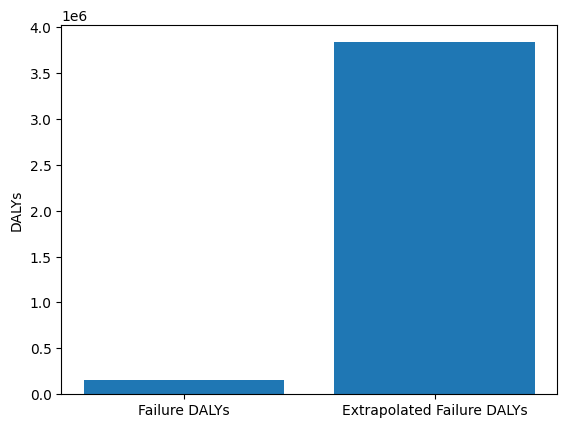

In [138]:
plt.bar(['Failure DALYs', 'Extrapolated Failure DALYs'],
        [failure_daly, extrapolated_failure_dalys])
plt.ylabel('DALYs')
plt.show()


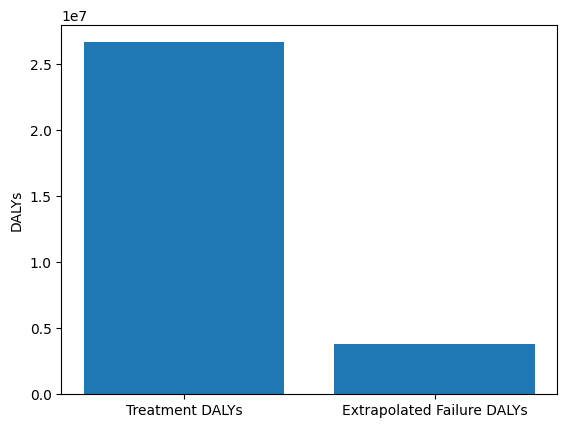

In [151]:

# Plot the total treatment DALYs, original total failure DALYs, and extrapolated failure DALYs
plt.bar(['Treatment DALYs', 'Extrapolated Failure DALYs'],
        [treatment_daly, extrapolated_failure_dalys])
plt.ylabel('DALYs')
plt.show()
